In [678]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline

df = pd.read_csv("tracks.csv")

In [679]:
df["popularity"].describe()

count    1500.000000
mean       28.554000
std        24.038587
min         0.000000
25%         1.000000
50%        25.000000
75%        47.000000
max        93.000000
Name: popularity, dtype: float64

In [680]:
m = df["popularity"].median()
print(m)

25.0


In [681]:
df["popularity_binary"] = df["popularity"].map(lambda x: 1 if x > m else 0)
df.drop(columns=["popularity"], inplace=True)

df["explicit"] = df["explicit"].map({True: 1, False: 0})
df = pd.get_dummies(df, columns=['key', 'time_signature', 'track_genre'], drop_first=True, dtype=int)


taking key and time sig look numeric but really categorical

In [682]:
df

,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5,track_genre_dance,track_genre_opera
0,202093,1,0.658,0.671,-12.210,1,0.0363,0.09330,0.000927,0.1150,...,0,0,0,0,0,0,1,0,0,0
1,215973,0,0.627,0.505,-12.659,1,0.0549,0.19700,0.014900,0.0583,...,0,0,0,0,0,0,1,0,0,0
2,188160,0,0.807,0.835,-6.849,0,0.0631,0.00148,0.527000,0.2330,...,0,1,0,0,0,0,1,0,0,0
3,233965,0,0.748,0.549,-5.447,0,0.0650,0.00268,0.792000,0.1960,...,0,0,0,0,0,0,1,0,0,0
4,187173,0,0.683,0.869,-4.828,1,0.0515,0.00088,0.836000,0.2060,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,352371,0,0.273,0.122,-22.173,0,0.0575,0.96000,0.003330,0.0635,...,0,0,0,0,0,0,1,0,0,1
1496,204310,0,0.457,0.498,-8.387,1,0.0368,0.76600,0.000002,0.2890,...,0,0,0,0,0,0,1,0,0,1
1497,225506,0,0.241,0.207,-16.353,1,0.0374,0.98200,0.002260,0.1140,...,0,0,0,0,1,0,0,0,0,1
1498,148600,0,0.280,0.208,-20.158,1,0.0521,0.94100,0.000200,0.4100,...,0,0,0,0,0,0,1,0,0,1


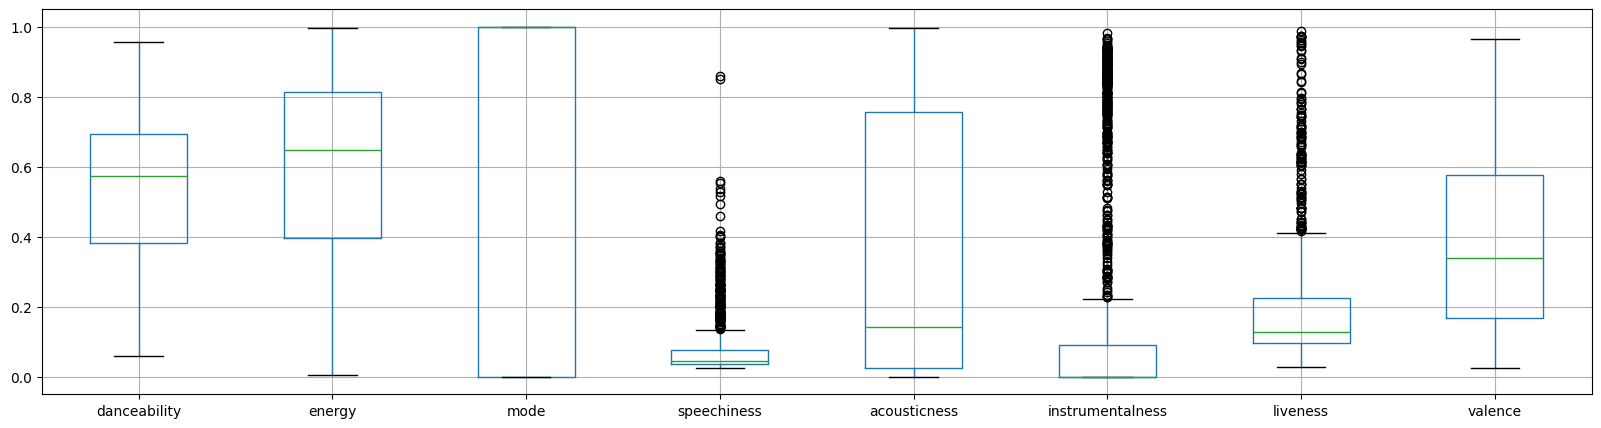

In [683]:
# look at all cols with vals between -1 and 1
cat_cols = df.columns[df.columns.str.contains('key_|time_signature_|track_genre_')].tolist()
df.drop(columns=["duration_ms", "tempo", "loudness", "explicit", "popularity_binary"] + cat_cols).boxplot(
    figsize=(20, 5))
plt.show()

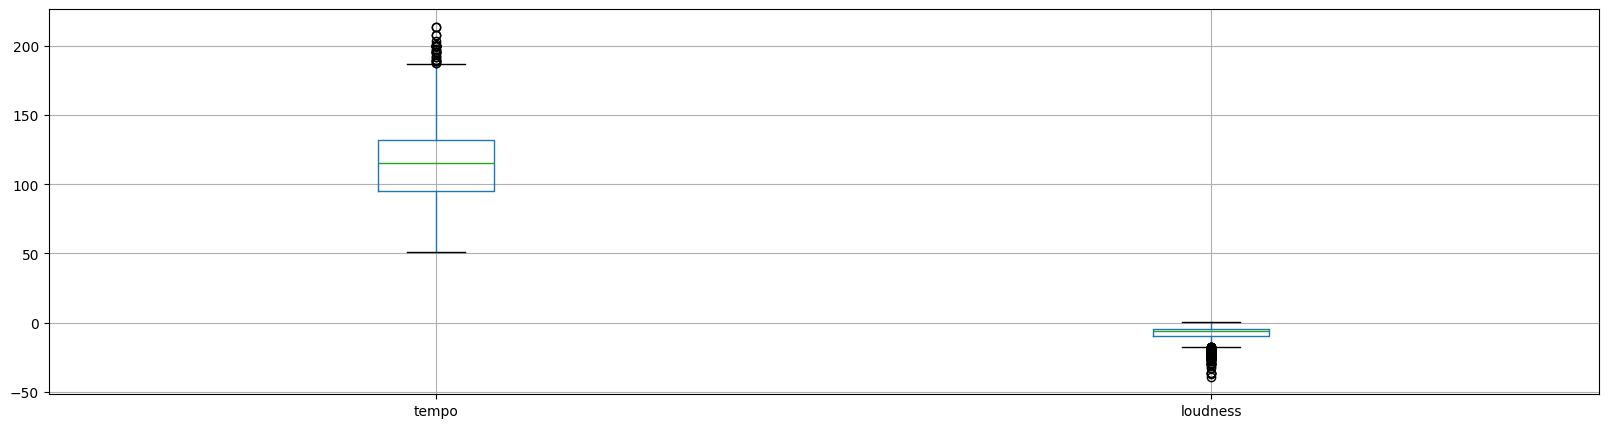

In [684]:
# look at all cols with vals between -1 and 1
df[["tempo", "loudness"]].boxplot(figsize=(20, 5))
plt.show()

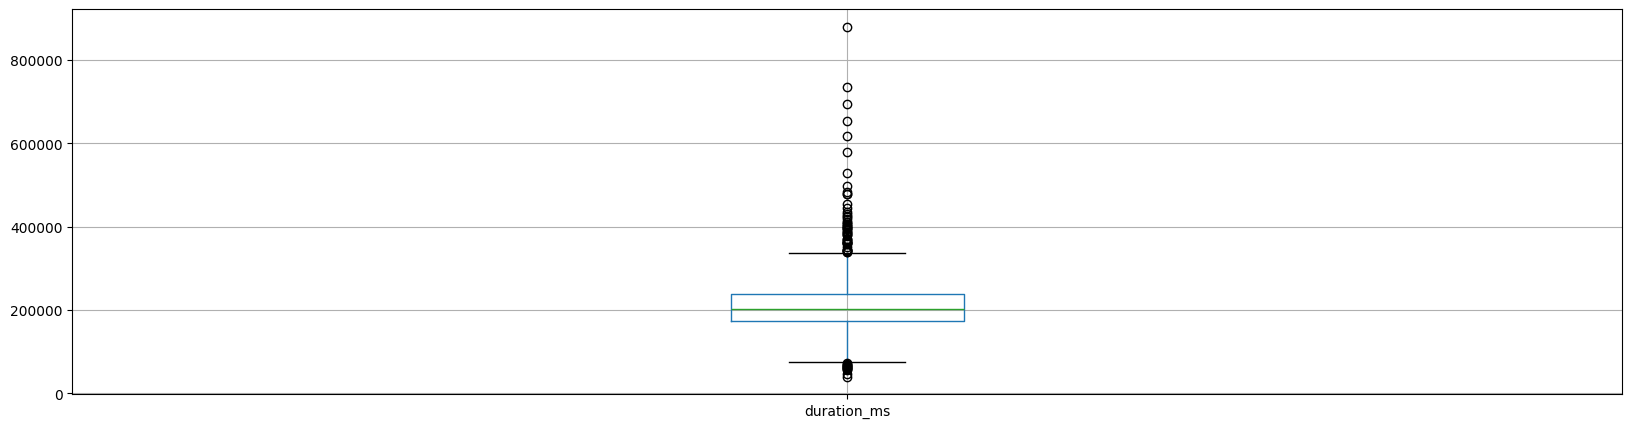

In [685]:
df[["duration_ms"]].boxplot(figsize=(20, 5))
plt.show()

outliers
- duration
- loudness
- speechiness
- instrumentalness
- liveness
- tempo

In [686]:
df.isna().sum()

duration_ms          0
explicit             0
danceability         0
energy               0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
popularity_binary    0
key_1                0
key_2                0
key_3                0
key_4                0
key_5                0
key_6                0
key_7                0
key_8                0
key_9                0
key_10               0
key_11               0
time_signature_1     0
time_signature_3     0
time_signature_4     0
time_signature_5     0
track_genre_dance    0
track_genre_opera    0
dtype: int64

In [687]:
df["explicit"].value_counts()

explicit
0    1343
1     157
Name: count, dtype: int64

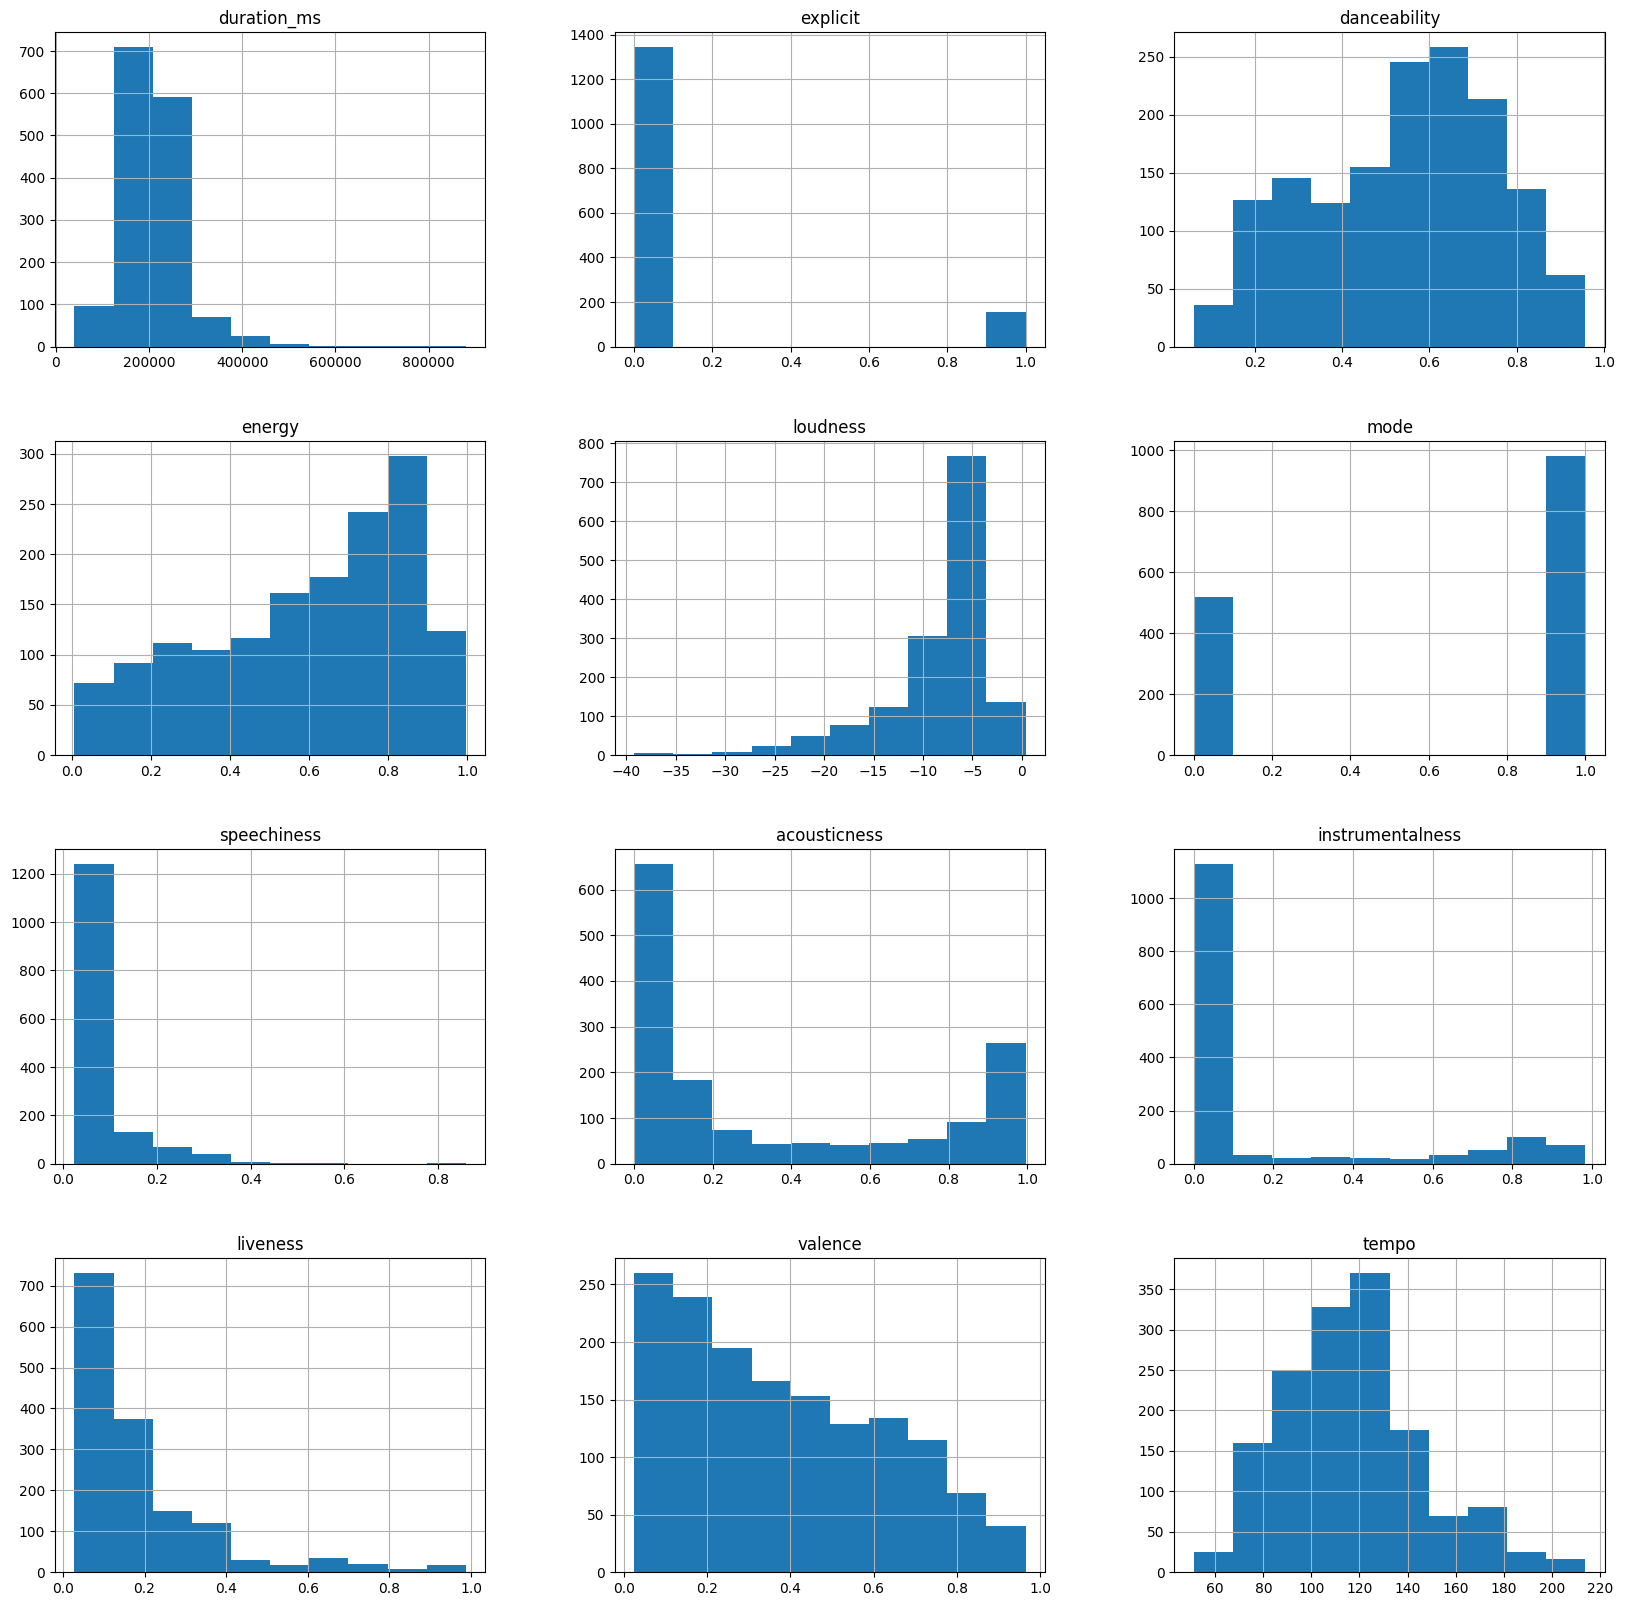

In [688]:
df.drop(columns=cat_cols + ["popularity_binary"]).hist(figsize=(20, 20))
plt.show()

In [689]:
len(df.columns)

30

In [690]:
# # df = df.sample(frac=0.5)
#
# orig_n = len(df)
#
# outlier_cols = [
#     "duration_ms",
#     "loudness",
#     "speechiness",
#     "instrumentalness",
#     "liveness",
#     "tempo",
# ]
#
# # (2) Compute cut-offs on THAT sample
# lower_q = df[outlier_cols].quantile(0.01)
# upper_q = df[outlier_cols].quantile(0.99)
#
# # (3) Now *sequentially* drop rows that fall outside each column’s [1%,99%] range
# for col in outlier_cols:
#     lo, hi = lower_q[col], upper_q[col]
#     df = df[df[col].between(lo, hi)]
#
# df = df.reset_index(drop=True)
#
# dropped = orig_n - len(df)
# print(f"Remaining rows: {len(df)} (dropped {dropped} rows out of {orig_n})")
#


tried this to remove extreme outliers but had little if any effect, idk if we wanna keep it in commented out and say that or just leave out completely?

In [691]:
# from sklearn.preprocessing import PolynomialFeatures
#

#
df['tempo_acousticness'] = df['tempo'] * df['acousticness']
df['danceability_energy'] = df['danceability'] * df['energy']
# df['loudness_valence'] = df['loudness'] * df['valence']
# df['duration_tempo'] = df['duration_ms'] * df['tempo']
#
# top_feats = ['tempo', 'acousticness', 'danceability', 'energy']
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# poly_arr = poly.fit_transform(df[top_feats])
# poly_cols = poly.get_feature_names_out(top_feats)
#
# poly_df = pd.DataFrame(poly_arr, columns=poly_cols, index=df.index)
# poly_new = poly_df.drop(columns=top_feats)
# df = pd.concat([df, poly_new], axis=1)

tried adding these features, little diff.

In [692]:
y = df['popularity_binary']
X = df.drop('popularity_binary', axis=1)

In [693]:
from sklearn.preprocessing import OneHotEncoder

# outliers
# - duration
# - loudness
# - speechiness
# - instrumentalness
# - liveness
# - tempo


columns_outliers_no_skew = ["speechiness", "instrumentalness", "liveness"]

columns_outliers_skewed = ['duration_ms', 'loudness', 'tempo']

columns_no_outliers_skewed = ["duration_ms",
                              "danceability",
                              "energy",
                              "loudness",
                              "speechiness",
                              "acousticness",
                              "instrumentalness",
                              "liveness",
                              "valence",
                              "tempo",
                              "tempo_acousticness",
                              "danceability_energy"
                              ]

columns_no_outliers_no_skew = [col for col in X.columns if
                               col not in columns_outliers_no_skew and col not in columns_no_outliers_skewed and col not in columns_outliers_skewed]

outliers_no_skew_pipeline = Pipeline(
    steps=[
        ("log_transform", PowerTransformer(method="yeo-johnson")),
        ("scaler", RobustScaler())
    ]
)

outliers_skewed_pipeline = Pipeline(steps=[
    ("log_transform", PowerTransformer(method="yeo-johnson")),
    ('scale', RobustScaler())
])

no_outliers_skewed_pipeline = Pipeline(
    steps=[
        ("log_transform", PowerTransformer(method="yeo-johnson")),
        ("scaler", MinMaxScaler())
    ]
)

no_outliers_no_skew_pipeline = Pipeline(
    steps=[
        ("scaler", MinMaxScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("outliers_skewed", outliers_skewed_pipeline, columns_outliers_skewed),
        ("outliers_not_skewed", outliers_no_skew_pipeline, columns_outliers_no_skew),
        ("no_outliers_skewed", no_outliers_skewed_pipeline, columns_no_outliers_skewed),
        ("no_outliers_no_skew", no_outliers_no_skew_pipeline, columns_no_outliers_no_skew)
    ],
    remainder="passthrough"
)

yeo-johnson instead of log transformation for skewed cols cause it handles negative values, and I think is a lil better (check this)

In [694]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [695]:
df["popularity_binary"].value_counts()

popularity_binary
0    784
1    716
Name: count, dtype: int64

In [696]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Random Forest

In [697]:
from sklearn.feature_selection import RFE

rfe_estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
rfe = RFE(estimator=rfe_estimator, step=0.1)

In [698]:
from sklearn.decomposition import PCA

pipe_rf = Pipeline(steps=[('preprocess', preprocess_pipeline),
                          ('feature_sel', rfe),
                          ('rf', RandomForestClassifier())])

In [699]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [8, 10, 15, 20],
    'feature_sel__n_features_to_select': [20, 25, 27, 30],
    'feature_sel__step': [0.1, 0.2, 0.3],
}

# search_rf = RandomizedSearchCV(
#     pipe_rf,
#     param_distributions=param_grid,
#     n_iter=30,  # try updating this
#     # scoring='roc_auc',
#     cv=cv,
#     n_jobs=-1,
#     random_state=42
# )

search_rf = GridSearchCV(pipe_rf, param_grid, n_jobs=-1, cv=5, refit=True)
search_rf.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search_rf.best_score_)
print("Best parameters: ", search_rf.best_params_)

RF_best_params = search_rf.best_params_
RF_best_model = search_rf.best_estimator_

# .765
# 0.777 with rfe

C:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best CV score = 0.780:
Best parameters:  {'feature_sel__n_features_to_select': 20, 'feature_sel__step': 0.2, 'rf__max_depth': 15, 'rf__n_estimators': 200}


## SVM

In [700]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

In [701]:
# # prepare a parameter grid
# param_grid = {
#     'svm__C': [0.1, 1, 10, 100],
#     'svm__gamma': [1, 0.1, 0.01, 0.001],
#     'svm__kernel': ['rbf', 'linear', 'poly']}
#
# search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
# search.fit(X_train, y_train)
#
# print("Best CV score = %0.3f:" % search.best_score_)
# print("Best parameters: ", search.best_params_)
#
# # store the best params and best model for later use
# SVM_best_params = search.best_params_
# SVM_best_model = search.best_estimator_

# Best CV score = 0.723:
# Best parameters:  {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

## KNN

In [702]:
# create the pipeline
pipe_knn = Pipeline(steps=[('preprocess', preprocess_pipeline),
                           ('feature_sel', rfe),
                           ('knn', KNeighborsClassifier())])

In [703]:
# prepare a parameter grid
param_grid = {
    'knn__n_neighbors': [4, 5, 10],
    'knn__weights': ["uniform", "distance"],
    'feature_sel__n_features_to_select': [20, 25, 27, 30],
    'feature_sel__step': [0.1, 0.2, 0.3],
}

search = GridSearchCV(pipe_knn, param_grid, n_jobs=-1, cv=5, refit=True)

search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.712:
Best parameters:  {'feature_sel__n_features_to_select': 30, 'feature_sel__step': 0.1, 'knn__n_neighbors': 10, 'knn__weights': 'distance'}


## XGB

In [704]:
from xgboost import XGBClassifier

pipe_xgb = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('feature_sel', rfe),
    ('xgb', XGBClassifier(
        n_jobs=-1,
        eval_metric='logloss',
        random_state=42
    )),
])

In [705]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_xgb = {
    'xgb__n_estimators': [500, 600, 700],
    'xgb__max_depth': [7, 8, 9, 10],
    'xgb__learning_rate': [0.001, 0.005, 0.01, 0.05],
    'xgb__subsample': [0.5, 0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'feature_sel__n_features_to_select': [18, 20, 25, 27, 30],
    'feature_sel__step': [0.1, 0.2, 0.3],
}

search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,
    # scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42
)
search_xgb.fit(X_train, y_train)

print("Best XGB CV:", search_xgb.best_score_)
print("Best XGB Params:", search_xgb.best_params_)

XGB_best_model = search_xgb.best_estimator_

# .765 with no feature selection stuff
# .766
# .769 with rfe

Best XGB CV: 0.7649999999999999
Best XGB Params: {'xgb__subsample': 0.6, 'xgb__n_estimators': 500, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 1.0, 'feature_sel__step': 0.3, 'feature_sel__n_features_to_select': 25}


## MLP

In [706]:
from sklearn.neural_network import MLPClassifier

pipe_mlp = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('pca', PCA()),
    ('clf', MLPClassifier(
        random_state=42,
        max_iter=200,
        early_stopping=True,
    )),
])

In [707]:
param_dist = {
    'clf__hidden_layer_sizes': [(100, 50), (100, 100), (150, 100), (150, 150)],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'clf__learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__learning_rate': ['constant', 'adaptive'],
    'pca__n_components': [5, 10, 15, 20],
    'pca__whiten': [False, True],
}

search_mlp = RandomizedSearchCV(
    pipe_mlp,
    param_distributions=param_dist,
    # n_iter=20,
    # scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
)
search_mlp.fit(X_train, y_train)

MLP_best_model = search_mlp.best_estimator_

print("Best MLP CV:", search_mlp.best_score_)
print("Best MLP params:", search_mlp.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best MLP CV: 0.7074999999999999
Best MLP params: {'pca__whiten': False, 'pca__n_components': 10, 'clf__learning_rate_init': 0.01, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (150, 150), 'clf__alpha': 0.001, 'clf__activation': 'relu'}


## Logistic Regression

In [708]:
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('pca', PCA()),
    ('clf', LogisticRegression(
        max_iter=1000, solver='saga', random_state=42
    )),
])

In [709]:
param_dist = {
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2'],
    'pca__n_components': [5, 10, 15, 20],
    'pca__whiten': [False, True],
}

search_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_dist,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
)
search_lr.fit(X_train, y_train)

LR_best_model = search_lr.best_estimator_

print("Best LR CV:", search_lr.best_score_)
print("Best LR params:", search_lr.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best LR CV: 0.7016666666666667
Best LR params: {'pca__whiten': True, 'pca__n_components': 20, 'clf__penalty': 'l2', 'clf__C': np.float64(0.1)}


## CatBoost

In [710]:
from catboost import CatBoostClassifier, Pool

pipe_cb = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('pca', PCA()),
    ('clf', CatBoostClassifier(
        random_seed=42,
        early_stopping_rounds=50,
        depth=4,
        l2_leaf_reg=10,
        verbose=False,
    )),
])

In [711]:
param_dist = {
    'clf__iterations': [200, 500, 800],
    'clf__depth': [4, 6, 8],
    'clf__learning_rate': [0.01, 0.03, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__rsm': [0.6, 0.8, 1.0],
    'clf__l2_leaf_reg': [1, 3, 5, 7, 9],
    'clf__bagging_temperature': [0.0, 0.2, 0.5, 1.0],
    'clf__random_strength': [0, 1, 2, 3],

    'pca__n_components': [5, 10, 15, 20],
    'pca__whiten': [False, True],
}

search_cb = RandomizedSearchCV(
    pipe_cb,
    param_distributions=param_dist,
    # n_iter=20,
    # scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
)
search_cb.fit(X_train, y_train)

CB_best_model = search_cb.best_estimator_

print("Best CB CV:", search_cb.best_score_)
print("Best CB params:", search_cb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CB CV: 0.7291666666666667
Best CB params: {'pca__whiten': True, 'pca__n_components': 20, 'clf__subsample': 1.0, 'clf__rsm': 0.8, 'clf__random_strength': 1, 'clf__learning_rate': 0.03, 'clf__l2_leaf_reg': 1, 'clf__iterations': 800, 'clf__depth': 8, 'clf__bagging_temperature': 0.5}


# Evaluation

In [712]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [713]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc


# taken from labs

# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1


def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]

    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    # compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # compute the area under the curve
    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [714]:
# SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)
XGB_accuracy, XGB_precision, XGB_recall, XGB_f1_score, XGB_tpr, XGB_auc = evaluate_model(X_test, y_test, XGB_best_model)
CB_accuracy, CB_precision, CB_recall, CB_f1_score, CB_tpr, CB_auc = evaluate_model(X_test, y_test, CB_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)
LR_accuracy, LR_precision, LR_recall, LR_f1_score, LR_tpr, LR_auc = evaluate_model(X_test, y_test, LR_best_model)

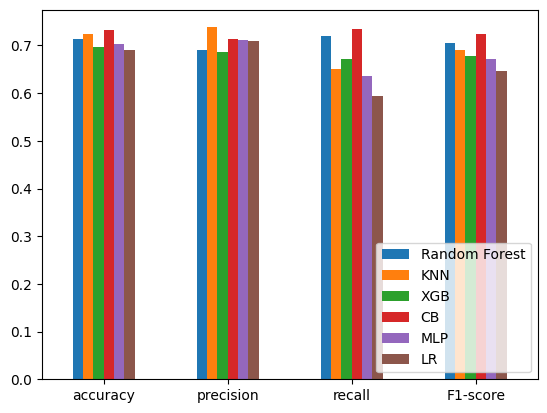

In [715]:
XGB_metrics = np.array([XGB_accuracy, XGB_precision, XGB_recall, XGB_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
CB_metrics = np.array([CB_accuracy, CB_precision, CB_recall, CB_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
LR_metrics = np.array([LR_accuracy, LR_precision, LR_recall, LR_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame(
    {'Random Forest': RF_metrics, 'KNN': KNN_metrics, "XGB": XGB_metrics, "CB": CB_metrics, "MLP": MLP_metrics, "LR": LR_metrics},
    index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Overall, CB is best.

KNN good accuracy, precision, recall drops off.
RF good accuracy precision and recall. Good across all.

looking at the 2 gradient boosting algorithms: XGB good overall, CB better.

MLP good accuracy and precision but worse recall and hence F1-score drops

LR good accuracy and precision, poor recall, hence poorer F1-score

In [720]:
print(f"Accuracy {CB_accuracy}")
print(f"Precision {CB_precision}")
print(f"Recall {CB_recall}")
print(f"F1-score {CB_f1_score}")

Accuracy 0.7333333333333333
Precision 0.7142857142857143
Recall 0.7342657342657343
F1-score 0.7241379310344828


In [717]:
print(f"Accuracy {KNN_accuracy}")
print(f"Precision {KNN_precision}")
print(f"Recall {KNN_recall}")
print(f"F1-score {KNN_f1_score}")

Accuracy 0.7233333333333334
Precision 0.7380952380952381
Recall 0.6503496503496503
F1-score 0.6914498141263941


Ensemble accuracy: 0.740
Ensemble precision: 0.730
Ensemble recall: 0.720
Ensemble F1-score: 0.725
Ensemble AUC-ROC: 0.815

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       157
           1       0.73      0.72      0.73       143

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300



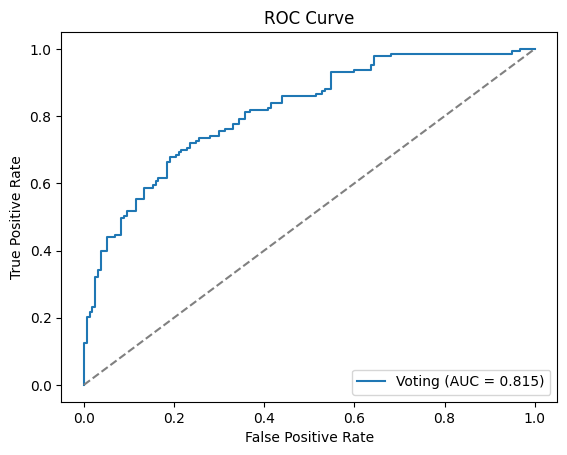

In [722]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import VotingClassifier

# combine models together to get slightly better results than any 1 of them in isolation
voting = VotingClassifier(
    estimators=[('rf', RF_best_model), ('cb', CB_best_model)],
    voting='soft',
)

voting.fit(X_train, y_train)
y_pred_v = voting.predict(X_test)
y_prob_v = voting.predict_proba(X_test)[:, 1]

# compute metrics
acc = accuracy_score(y_test, y_pred_v)
prec = precision_score(y_test, y_pred_v)
rec = recall_score(y_test, y_pred_v)
f1 = f1_score(y_test, y_pred_v)
auc = roc_auc_score(y_test, y_prob_v)

print(f"Ensemble accuracy: {acc:.3f}")
print(f"Ensemble precision: {prec:.3f}")
print(f"Ensemble recall: {rec:.3f}")
print(f"Ensemble F1-score: {f1:.3f}")
print(f"Ensemble AUC-ROC: {auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_v))

fpr, tpr, _ = roc_curve(y_test, y_prob_v)
plt.figure()
plt.plot(fpr, tpr, label=f'Voting (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

.8 area is pretty good considering

In [719]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train, discrete_features='auto')
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
print(mi_series.head(10))

# this shows the amount of information per column (in bits????)
# needa check exactly what this mean

danceability_energy    0.118736
acousticness           0.117602
loudness               0.116161
tempo                  0.108634
energy                 0.099544
tempo_acousticness     0.094334
valence                0.076604
duration_ms            0.076256
danceability           0.073445
instrumentalness       0.052762
dtype: float64
